<a href="https://colab.research.google.com/github/Balogunhabeeb14/Petroleum-Target-Xplorer/blob/main/Recent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from yellowbrick.model_selection import RFECV
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegression, SGDClassifier, LinearRegression
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_validate
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score  # Add this
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [4]:

def load_excel_sheets(file_path):
    '''Load all sheets from an Excel file and return a dictionary of DataFrames.'''
    xls = pd.ExcelFile(file_path)
    sheet_names = xls.sheet_names
    dfs = {}
    for sheet_name in sheet_names:
        try:
            dfs[sheet_name] = pd.read_excel(file_path, sheet_name=sheet_name)
            print(f"DataFrame loaded successfully for sheet: {sheet_name}")
        except Exception as e:
            print(f"Error loading DataFrame for sheet: {sheet_name}")
            print(e)
    return dfs


def drop_unnamed_columns(df):
    '''Drop columns with names containing 'Unnamed' from a DataFrame.'''
    # Filter columns containing 'Unnamed' in their names
    unnamed_columns = [col for col in df.columns if 'Unnamed' in col]

    # Drop the identified columns
    df.drop(columns=unnamed_columns, inplace=True)

    # Return the DataFrame with unnamed columns dropped
    return df

def missing_value_percent(df):
    '''Calculate the percentage of missing values in each column of a DataFrame.'''
    # Calculate the total number of missing values in each column
    missing_values = df.isna().sum()

    # Calculate the total number of values in each column
    total_values = df.shape[0]

    # Calculate the percentage of missing values for each column
    missing_percent = (missing_values / total_values) * 100

    # Create a DataFrame to store the results
    missing_df = pd.DataFrame({
        'Column': missing_percent.index,
        'Missing_Percent': missing_percent.values
    })

    return missing_df

def drop_high_missing_columns(df, threshold):
    '''Drop columns with more than a specified percentage of missing values from a DataFrame.'''
    # Calculate the percentage of missing values for each column
    missing_percent = (df.isna().sum() / df.shape[0]) * 100

    # Filter columns with missing value percentage greater than the threshold
    high_missing_columns = missing_percent[missing_percent > threshold].index

    # Drop the identified columns from the DataFrame
    df.drop(columns=high_missing_columns, inplace=True)

    return df

def impute_missing(df):
    """
    Impute missing values in a DataFrame using appropriate methods based on the data distribution.

    Parameters:
        df (DataFrame): The DataFrame containing the features.

    Returns:
        DataFrame: The DataFrame with missing values imputed.
    """
    for column in df.columns:
        if df[column].dtype == 'object':
            # For categorical data, impute with mode
            mode_val = df[column].mode()[0]
            df[column].fillna(mode_val, inplace=True)
            print(f"Imputed missing values in '{column}' with mode: {mode_val}")
        elif np.abs(df[column].skew()) > 1:
            # For highly skewed numerical data, impute with median
            median_val = df[column].median()
            df[column].fillna(median_val, inplace=True)
            print(f"Imputed missing values in '{column}' with median: {median_val}")
        else:
            # For approximately normally distributed numerical data, impute with mean
            mean_val = df[column].mean()
            df[column].fillna(mean_val, inplace=True)
            print(f"Imputed missing values in '{column}' with mean: {mean_val}")

    return df

def plot_correlation_matrix(df):
    """
    Plot correlation matrix and identify multicollinearity.

    Parameters:
        df (DataFrame): The DataFrame containing the features.

    Returns:
        None
    """
    # Calculate correlation matrix
    corr_matrix = df.corr()

    # Set the plot style (change 'whitegrid' to other styles like 'darkgrid', 'white', 'dark', or 'ticks')
    sns.set_style("white")

    # Plot heatmap with new colormap and style
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='tab10', fmt=".2f", annot_kws={"size": 8, "color": 'black'})
    plt.title('Correlation Matrix')
    plt.show()

    # Check for multicollinearity
    collinear_features = set()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > 0.7:
                colname = corr_matrix.columns[i]
                collinear_features.add(colname)

    if collinear_features:
        print("The following variables are highly correlated (>|0.7|):")
        print(collinear_features)
    else:
        print("No multicollinearity detected.")



def evaluate_regression_model(X, y):
    # Split data into train and test sets (for visualization)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define the regression model
    model = RandomForestRegressor()

    # 5-Fold Cross-Validation
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    mse_scores = -cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv)
    rmse_scores = np.sqrt(mse_scores)
    mae_scores = -cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv)
    r2_scores = cross_val_score(model, X, y, scoring='r2', cv=cv)

    # Print the cross-validated metrics
    print(f"Cross-Validated MSE: {mse_scores.mean():.2f} ± {mse_scores.std():.2f}")
    print(f"Cross-Validated RMSE: {rmse_scores.mean():.2f} ± {rmse_scores.std():.2f}")
    print(f"Cross-Validated MAE: {mae_scores.mean():.2f} ± {mae_scores.std():.2f}")
    print(f"Cross-Validated R^2: {r2_scores.mean():.2f} ± {r2_scores.std():.2f}")

    # Fit the model to the training data (for visualization purposes)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calculate the metrics for this specific test set
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)
    r_squared = r2_score(y_test, y_pred)

    # Plot true vs predicted values
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, color='blue', label='Predictions')  # Predicted values in blue
    plt.scatter(y_test, y_test, color='red', label='True Values')  # True values in red
    plt.xlabel("True Values")
    plt.ylabel("Predictions")
    plt.title("TOC Prediction for Kolmani River 2")
    plt.grid(True)
    plt.legend()

    # Display evaluation metrics on the chart
    metrics_text = f"MSE: {mse:.2f}\nRMSE: {rmse:.2f}\nMAE: {mae:.2f}\nR^2: {r_squared:.2f}"
    plt.text(0.1, 0.6, metrics_text, transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

    plt.tight_layout()
    plt.show()



def evaluate_classification_model(X, y):
    # Split data into train and test sets (for visualization)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define the classification model
    model = RandomForestClassifier()

    # 5-Fold Cross-Validation
    cv = KFold(n_splits=5, shuffle=True, random_state=42)

    accuracy_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv)
    precision_scores = cross_val_score(model, X, y, scoring='precision', cv=cv)
    recall_scores = cross_val_score(model, X, y, scoring='recall', cv=cv)
    f1_scores = cross_val_score(model, X, y, scoring='f1', cv=cv)
    roc_auc_scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv)

    # Print the cross-validated metrics
    print(f"Cross-Validated Accuracy: {accuracy_scores.mean():.2f} ± {accuracy_scores.std():.2f}")
    print(f"Cross-Validated Precision: {precision_scores.mean():.2f} ± {precision_scores.std():.2f}")
    print(f"Cross-Validated Recall: {recall_scores.mean():.2f} ± {recall_scores.std():.2f}")
    print(f"Cross-Validated F1-Score: {f1_scores.mean():.2f} ± {f1_scores.std():.2f}")
    print(f"Cross-Validated ROC-AUC: {roc_auc_scores.mean():.2f} ± {roc_auc_scores.std():.2f}")

    # Fit the model to the training data (for visualization purposes)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1]  # Probabilities for ROC-AUC

    # Calculate metrics for this specific test set
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_prob)

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC-AUC: {roc_auc:.2f}', color='blue')
    plt.plot([0, 1], [0, 1], linestyle='--', color='red')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Display evaluation metrics
    print(f"Test Set Accuracy: {accuracy:.2f}")
    print(f"Test Set Precision: {precision:.2f}")
    print(f"Test Set Recall: {recall:.2f}")
    print(f"Test Set F1-Score: {f1:.2f}")
    print(f"Test Set ROC-AUC: {roc_auc:.2f}")



In [5]:
# Load all sheets from the Excel file
file_path='/content/Passey.xlsx'
dfs=load_excel_sheets(file_path)

# Create list of tuples containing DataFrame and sheet name
df_list = [(df, sheet_name) for sheet_name, df in dfs.items()]

DataFrame loaded successfully for sheet: Data Summary
DataFrame loaded successfully for sheet: TOC-ESTM (KR-2)
DataFrame loaded successfully for sheet: TOC-ESTM (KR-3) (edittt)
DataFrame loaded successfully for sheet: TOC-ESTM (KR-3)
DataFrame loaded successfully for sheet: Sheet2
DataFrame loaded successfully for sheet: Sheet1


In [6]:
# Access the loaded DataFrames
data_summary_df = dfs['Data Summary']
KR2 = dfs['TOC-ESTM (KR-2)']
KR3_edit = dfs['TOC-ESTM (KR-3) (edittt)']
KR3=dfs['TOC-ESTM (KR-3)']
sheet2_df = dfs['Sheet2']
sheet1_df = dfs['Sheet1']

In [7]:
data_summary_df.head(40)

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3
0,DATA,NaN,Kolmani River -2,Kolmani River -3
1,Well Head,NaN,Y,Y
2,Deviation data,NaN,Y,Y
3,Litho-logs,Spectral Gamma,Y,N
4,NaN,GR,Y,Y
5,NaN,SP,N,N
6,NaN,Mud-log,Y,Y
7,NaN,Caliper,Y,Y
8,Porosity,DT,Y,Y
9,NaN,RHOB,Y,Y


The data summary provides us with the metadata for the data. Herein, few observations found includes:

- Litho-logs comprise features {Spectral Gamma, GR, SP, Mud-log, Caliper}
- Porosity	comprises features {DT,	RHOB, CNL}
- RES	comprises features {LLD, LLS}
- Biostratigraphic Data
- Well-Tops/Formation Tops
- Reports	comprises features {Geologic,	Rock-Eval}
- Rock-Eval	comprises features {S1, S2, S3,	HI,	OI, VR,	TOC, Tmax}

These features were collected mostly for Kolmani river 2(KR2) and Kolmani river 3(KR3). To have a fair analysis, we will only include features that are available in both KR2 & KR3.

PS. Most of the Multivariate linear regression analysis was repeated to confirm the dependent variable, what was discovered was that, the TOC(measured) was the actual variable predicted across all analysis.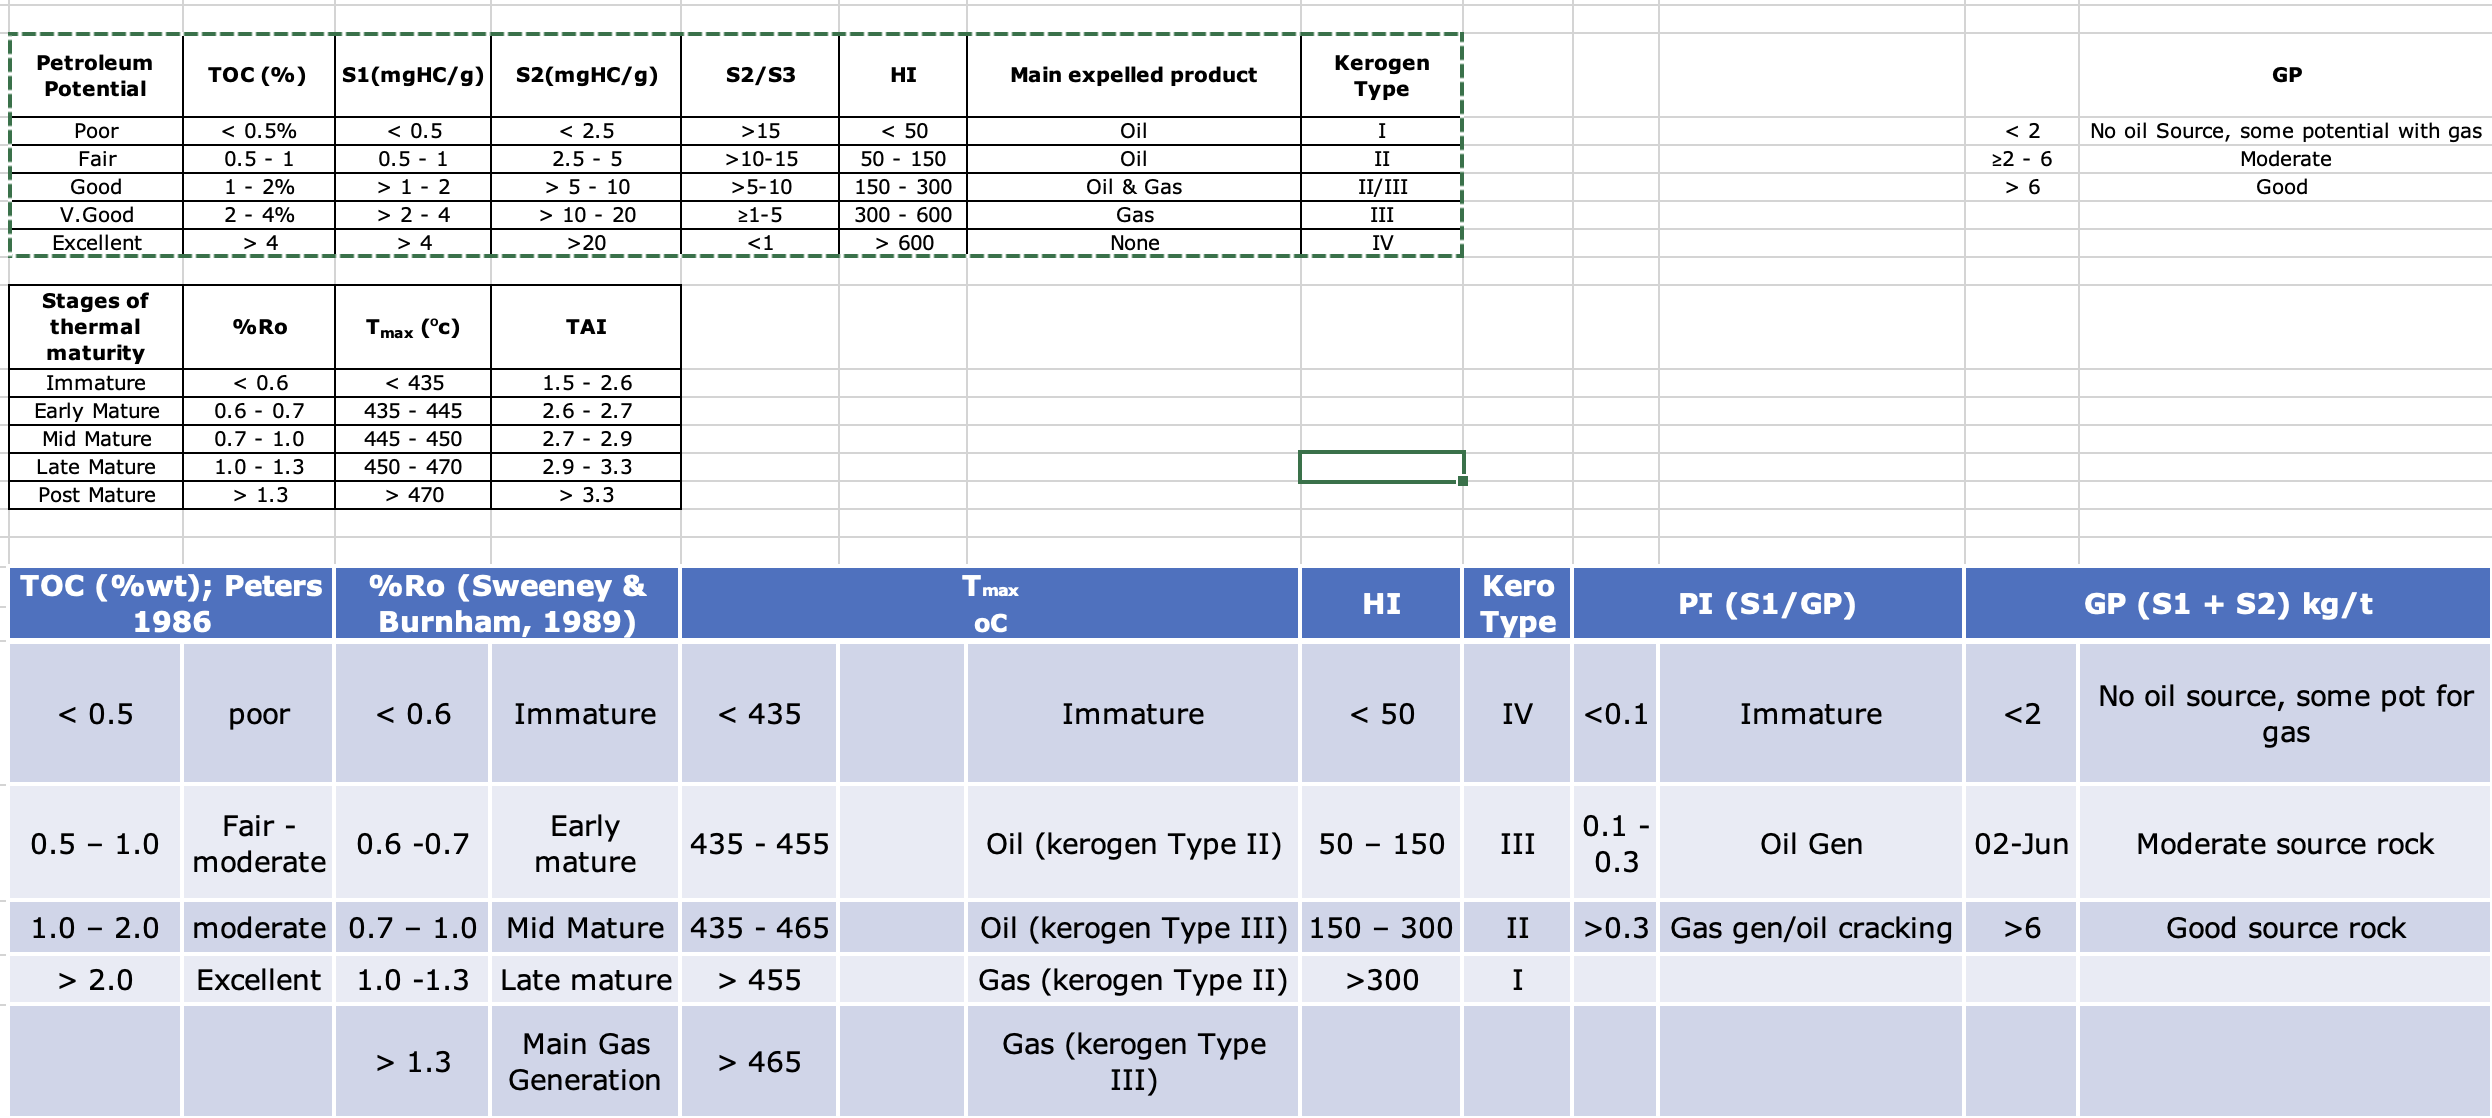



In [8]:
KR2.head()

,Automated Section/Plots,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,TOC (M-Pas-LOM11) +0.8,TOC (M-Pas-LOM12) +0.8,TOC (M-Pas),TOC (Schm),"TOC (GR, RHOB)","TOC (GR, RHOB,NPHI)","TOC (GR, RHOB,DT)",TOC (Rk-Eval),Measured-TOC,STDEV
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.8686,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.8669,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.8652,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.8635,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.8618,NaN


In [9]:
KR3.head()

,AUTOMATED SECTION,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 117,Unnamed: 118,Unnamed: 119,Unnamed: 120,Unnamed: 121,Unnamed: 122,Unnamed: 123,Unnamed: 124,Unnamed: 125,Unnamed: 126
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


There are few columns that are unnamed and not useful that needs to be dropped. we can use the drop_unnamed_columns function


In [7]:
KR2=drop_unnamed_columns(KR2)
KR3=drop_unnamed_columns(KR3)

In [11]:
KR2.head()

,Automated Section/Plots,Pot-Source,Source/Non-Source,RES,MD,GR,RES.1,DT,RHOB,NEU,...,TOC (M-Pas-LOM11) +0.8,TOC (M-Pas-LOM12) +0.8,TOC (M-Pas),TOC (Schm),"TOC (GR, RHOB)","TOC (GR, RHOB,NPHI)","TOC (GR, RHOB,DT)",TOC (Rk-Eval),Measured-TOC,STDEV
0,NaN,NaN,NaN,NaN,4978.00,40.4902,1970.836,56.5478,1.6991,51.6765,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.8686,NaN
1,NaN,NaN,NaN,NaN,4978.25,40.3001,1968.455,56.0224,1.7037,53.4121,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.8669,NaN
2,NaN,NaN,NaN,NaN,4978.50,38.8794,1966.763,56.0224,1.7081,50.7708,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.8652,NaN
3,NaN,NaN,NaN,NaN,4978.75,37.9678,1966.763,55.3079,1.7130,57.6586,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.8635,NaN
4,NaN,NaN,NaN,NaN,4979.00,37.4406,1962.986,55.3079,1.7149,59.4048,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.8618,NaN


In [12]:
KR3.head()

,AUTOMATED SECTION,Source/Non-source,MD,Gamma-Ray,R90,RHOB,Neutron,P-sonic,LOM,AI,...,"TOC (GR, RHOB)","TOC (GR, RHOB,NPHI)","TOC (GR, RHOB,DT)",Measured-TOC,TOC (Rk-Eval),STDEV (TOC-Passey vs TOC-Rx Eval),STDEV (TOC-M-Passey vs TOC-Rx Eval),STDEV (TOC-GR-RHOB vs TOC-Rx Eval),Measured-TOC.1,STDEV
0,NaN,GOM-FIK,5286.00,39.97,2000.0,0.0,0.5978,0.0,10.0,-999.25,...,6.653870,NaN,23.673922,0.734000,0.02,NaN,0.085589,NaN,0.734000,NaN
1,NaN,NaN,5286.25,39.78,2000.0,0.0,0.6039,0.0,10.0,-999.25,...,6.653043,NaN,23.673428,0.735271,0.03,NaN,0.078518,NaN,0.735271,NaN
2,NaN,NaN,5286.50,39.30,2000.0,0.0,0.5645,0.0,10.0,-999.25,...,6.650955,NaN,23.672180,0.736542,0.03,NaN,0.078518,NaN,0.736542,NaN
3,NaN,NaN,5286.75,39.26,2000.0,0.0,0.5120,0.0,10.0,-999.25,...,6.650781,NaN,23.672076,0.737813,0.04,NaN,0.071447,NaN,0.737813,NaN
4,NaN,NaN,5287.00,39.51,2000.0,0.0,0.5048,0.0,10.0,-999.25,...,6.651869,NaN,23.672726,0.739083,0.04,NaN,0.071447,NaN,0.739083,NaN


As we can see the unnamed columns has reduced. Its time to deal with missing data (NAN)

In [13]:
missing_value_percent(KR2) #display the missing values in KR2

,Column,Missing_Percent
0,Automated Section/Plots,99.958608
1,Pot-Source,100.000000
2,Source/Non-Source,99.997043
3,RES,99.952695
4,MD,0.002957
5,GR,0.002957
6,RES.1,0.002957
7,DT,0.002957
8,RHOB,0.002957
9,NEU,0.002957


In [14]:
missing_value_percent(KR3) #missing values in the KR3 data

,Column,Missing_Percent
0,AUTOMATED SECTION,100.000000
1,Source/Non-source,99.968042
2,MD,27.809913
3,Gamma-Ray,29.008341
4,R90,27.921767
5,RHOB,27.809913
6,Neutron,28.701544
7,P-sonic,27.809913
8,LOM,72.711003
9,AI,27.809913


As seen, there are many missing values in the columns, lets also explore the descriptive statistics to better understand the data.

In [15]:
KR2.describe().T

,count,mean,std,min,25%,50%,75%,max
Pot-Source,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MD,33822.0,9299.446529,2546.376800,4978.000000,7091.812500,9205.625000,11582.187500,13696.000000
GR,33822.0,68.163080,570.921839,-9999.000000,75.592525,91.163400,117.229975,247.242700
RES.1,33822.0,31.223275,115.871232,-9999.000000,7.125050,12.190400,29.606275,1999.390000
DT,33822.0,39.311113,599.334320,-9999.000000,62.662375,67.533950,76.773700,171.481400
RHOB,33822.0,1.072673,121.598205,-9999.000000,2.508900,2.558600,2.604000,2.962500
NEU,33822.0,1.247301,361.121576,-9999.000000,6.149450,9.728550,16.555600,73.249700
AI,502.0,156.674956,11.540989,126.738809,149.857818,153.770631,159.811026,219.969938
LOM,7881.0,10.000000,0.000000,10.000000,10.000000,10.000000,10.000000,10.000000
TOC (Schmoker),0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
KR3.describe().T

,count,mean,std,min,25%,50%,75%,max
AUTOMATED SECTION,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MD,22589.0,8.109500e+03,1.630257e+03,5286.000000,6.697750e+03,8.109500e+03,9.521250e+03,1.093300e+04
Gamma-Ray,22214.0,1.153963e+02,3.536899e+01,32.710000,8.749000e+01,1.093000e+02,1.383900e+02,2.343000e+02
R90,22554.0,1.522819e+01,9.609492e+01,0.516500,2.998350e+00,8.871200e+00,1.489443e+01,2.000000e+03
RHOB,22589.0,-8.163732e+00,1.029226e+02,-999.250000,2.484700e+00,2.540400e+00,2.586300e+00,2.723200e+00
Neutron,22310.0,1.627761e-01,9.229879e-02,-0.012900,9.380000e-02,1.345000e-01,2.385000e-01,6.039000e-01
P-sonic,22589.0,7.522636e+01,7.879241e+01,-999.250000,6.557000e+01,7.239000e+01,9.230000e+01,1.368800e+02
LOM,8539.0,1.000000e+01,0.000000e+00,10.000000,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01
AI,22589.0,3.256898e+04,8.388900e+03,-999.250000,2.686321e+04,3.446803e+04,3.872412e+04,4.859355e+04
S-imp.,22589.0,1.847587e+04,6.615405e+03,-999.250000,1.323555e+04,2.006530e+04,2.354492e+04,3.180393e+04


Clearly both in KR2 and KR3 there are columns with no entry at all. We will be dealing with missing data by deleting columns with more than 50% missingness.

In [8]:
#drop columns with more than 70% missingness
KR2 = drop_high_missing_columns(KR2, threshold=50)
KR3 = drop_high_missing_columns(KR3, threshold=50)

In [18]:
KR2.describe().T

,count,mean,std,min,25%,50%,75%,max
MD,33822.0,9299.446529,2546.376800,4978.000000,7091.812500,9205.625000,11582.187500,13696.000000
GR,33822.0,68.163080,570.921839,-9999.000000,75.592525,91.163400,117.229975,247.242700
RES.1,33822.0,31.223275,115.871232,-9999.000000,7.125050,12.190400,29.606275,1999.390000
DT,33822.0,39.311113,599.334320,-9999.000000,62.662375,67.533950,76.773700,171.481400
RHOB,33822.0,1.072673,121.598205,-9999.000000,2.508900,2.558600,2.604000,2.962500
NEU,33822.0,1.247301,361.121576,-9999.000000,6.149450,9.728550,16.555600,73.249700
ΔLogR,25105.0,-0.361215,12.717951,-403.226129,-0.255370,-0.109000,0.212843,3.043775
Measured-TOC,33817.0,0.848281,0.338911,0.244000,0.572200,0.806288,1.021000,3.382000


In [19]:
KR3.describe().T

,count,mean,std,min,25%,50%,75%,max
MD,22589.0,8.109500e+03,1.630257e+03,5286.000000,6.697750e+03,8.109500e+03,9.521250e+03,1.093300e+04
Gamma-Ray,22214.0,1.153963e+02,3.536899e+01,32.710000,8.749000e+01,1.093000e+02,1.383900e+02,2.343000e+02
R90,22554.0,1.522819e+01,9.609492e+01,0.516500,2.998350e+00,8.871200e+00,1.489443e+01,2.000000e+03
RHOB,22589.0,-8.163732e+00,1.029226e+02,-999.250000,2.484700e+00,2.540400e+00,2.586300e+00,2.723200e+00
Neutron,22310.0,1.627761e-01,9.229879e-02,-0.012900,9.380000e-02,1.345000e-01,2.385000e-01,6.039000e-01
P-sonic,22589.0,7.522636e+01,7.879241e+01,-999.250000,6.557000e+01,7.239000e+01,9.230000e+01,1.368800e+02
AI,22589.0,3.256898e+04,8.388900e+03,-999.250000,2.686321e+04,3.446803e+04,3.872412e+04,4.859355e+04
S-imp.,22589.0,1.847587e+04,6.615405e+03,-999.250000,1.323555e+04,2.006530e+04,2.354492e+04,3.180393e+04
P/S vel.ratio,22589.0,-7.710150e+00,9.742871e+01,-999.250000,1.640000e+00,1.710000e+00,1.970000e+00,2.980000e+00
Poissons ratio,22589.0,-9.291039e+00,9.727287e+01,-999.250000,2.000000e-01,2.400000e-01,3.300000e-01,4.400000e-01


Clearly, we still have missing values but the columns with significant missingness has now been dropped

Next, we have impute_missing function, here we are following the logic for the columns with categorical data to be replaced by their modes while numeric data to be replaced by their mean assuming the numeric columns are normally distributed.

In [9]:
impute_missing(KR2)

Imputed missing values in 'MD' with mean: 9299.446528886523
Imputed missing values in 'GR' with median: 91.1634
Imputed missing values in 'RES.1' with median: 12.1904
Imputed missing values in 'DT' with median: 67.53395
Imputed missing values in 'RHOB' with median: 2.5586
Imputed missing values in 'NEU' with median: 9.72855
Imputed missing values in 'ΔLogR' with median: -0.1089999633264126
Imputed missing values in 'Measured-TOC' with median: 0.8062875271


,MD,GR,RES.1,DT,RHOB,NEU,ΔLogR,Measured-TOC
0,4978.00,40.4902,1970.8360,56.5478,1.6991,51.6765,1.556562,0.868600
1,4978.25,40.3001,1968.4550,56.0224,1.7037,53.4121,1.535021,0.866900
2,4978.50,38.8794,1966.7630,56.0224,1.7081,50.7708,1.534648,0.865200
3,4978.75,37.9678,1966.7630,55.3079,1.7130,57.6586,1.506068,0.863500
4,4979.00,37.4406,1962.9860,55.3079,1.7149,59.4048,1.505233,0.861800
...,...,...,...,...,...,...,...,...
33818,13695.00,-9999.0000,42.0689,-9999.0000,-9999.0000,-9999.0000,-0.109000,0.609000
33819,13695.25,-9999.0000,40.3133,-9999.0000,-9999.0000,-9999.0000,-0.109000,0.591000
33820,13695.50,-9999.0000,39.0027,-9999.0000,-9999.0000,-9999.0000,-0.109000,0.573000
33821,13695.75,-9999.0000,37.9896,-9999.0000,-9999.0000,-9999.0000,-0.109000,0.555000


In [10]:
missing_value_percent(KR2)

,Column,Missing_Percent
0,MD,0.0
1,GR,0.0
2,RES.1,0.0
3,DT,0.0
4,RHOB,0.0
5,NEU,0.0
6,ΔLogR,0.0
7,Measured-TOC,0.0


There is no more missing value in the KR2 now, we will try same for KR3

In [11]:
impute_missing(KR3)

Imputed missing values in 'MD' with mean: 8109.5
Imputed missing values in 'Gamma-Ray' with mean: 115.39626316737193
Imputed missing values in 'R90' with median: 8.8712
Imputed missing values in 'RHOB' with median: 2.5404
Imputed missing values in 'Neutron' with mean: 0.1627760824742268
Imputed missing values in 'P-sonic' with median: 72.39
Imputed missing values in 'AI' with median: 34468.03
Imputed missing values in 'S-imp.' with mean: 18475.87286688211
Imputed missing values in 'P/S vel.ratio' with median: 1.71
Imputed missing values in 'Poissons ratio' with median: 0.24
Imputed missing values in 'Lambda*Rho' with median: 35172490000000.0
Imputed missing values in 'Mu*Rho' with mean: 35777357691250.4
Imputed missing values in 'Log10(RES)' with mean: 0.8161882221526374
Imputed missing values in 'ΔLogR' with median: -0.09771328428108893
Imputed missing values in 'TOC (M-Pas-LOM11)' with median: 0.0
Imputed missing values in 'TOC (M-Pas-LOM12)' with median: 0.0
Imputed missing values i

,MD,Gamma-Ray,R90,RHOB,Neutron,P-sonic,AI,S-imp.,P/S vel.ratio,Poissons ratio,...,Log10(RES),ΔLogR,TOC (M-Pas-LOM11),TOC (M-Pas-LOM12),TOC (M-Pas-LOM11) +0.8,TOC (M-Pas-LOM12) +0.8,Measured-TOC,TOC (Rk-Eval),STDEV (TOC-M-Passey vs TOC-Rx Eval),Measured-TOC.1
0,5286.00,39.970000,2000.0000,0.0000,0.597800,0.00,-999.25,-999.250000,-999.25,-999.25,...,3.301030,-0.698970,-0.971983,-0.658959,-0.171983,0.141041,0.734000,0.02,0.085589,0.734000
1,5286.25,39.780000,2000.0000,0.0000,0.603900,0.00,-999.25,-999.250000,-999.25,-999.25,...,3.301030,-0.698970,-0.971983,-0.658959,-0.171983,0.141041,0.735271,0.03,0.078518,0.735271
2,5286.50,39.300000,2000.0000,0.0000,0.564500,0.00,-999.25,-999.250000,-999.25,-999.25,...,3.301030,-0.698970,-0.971983,-0.658959,-0.171983,0.141041,0.736542,0.03,0.078518,0.736542
3,5286.75,39.260000,2000.0000,0.0000,0.512000,0.00,-999.25,-999.250000,-999.25,-999.25,...,3.301030,-0.698970,-0.971983,-0.658959,-0.171983,0.141041,0.737813,0.04,0.071447,0.737813
4,5287.00,39.510000,2000.0000,0.0000,0.504800,0.00,-999.25,-999.250000,-999.25,-999.25,...,3.301030,-0.698970,-0.971983,-0.658959,-0.171983,0.141041,0.739083,0.04,0.071447,0.739083
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31286,8109.50,115.396263,8.8712,2.5404,0.162776,72.39,34468.03,18475.872867,1.71,0.24,...,0.816188,-0.097713,0.000000,0.000000,0.800000,0.800000,0.774628,0.93,0.091924,0.774628
31287,8109.50,115.396263,8.8712,2.5404,0.162776,72.39,34468.03,18475.872867,1.71,0.24,...,0.816188,-0.097713,0.000000,0.000000,0.800000,0.800000,0.774628,0.93,0.091924,0.774628
31288,8109.50,115.396263,8.8712,2.5404,0.162776,72.39,34468.03,18475.872867,1.71,0.24,...,0.816188,-0.097713,0.000000,0.000000,0.800000,0.800000,0.774628,0.93,0.091924,0.774628
31289,8109.50,115.396263,8.8712,2.5404,0.162776,72.39,34468.03,18475.872867,1.71,0.24,...,0.816188,-0.097713,0.000000,0.000000,0.800000,0.800000,0.774628,0.93,0.091924,0.774628


In [12]:
missing_value_percent(KR3)

,Column,Missing_Percent
0,MD,0.0
1,Gamma-Ray,0.0
2,R90,0.0
3,RHOB,0.0
4,Neutron,0.0
5,P-sonic,0.0
6,AI,0.0
7,S-imp.,0.0
8,P/S vel.ratio,0.0
9,Poissons ratio,0.0


Clearly, both KR2 and KR3 are free of the missing data now. Quickly, we can check the normality of the data as its an assumption of statistical Multivariate analysis, however, we already assumed they are normal. so we will proceed to check the relationships (correlation)

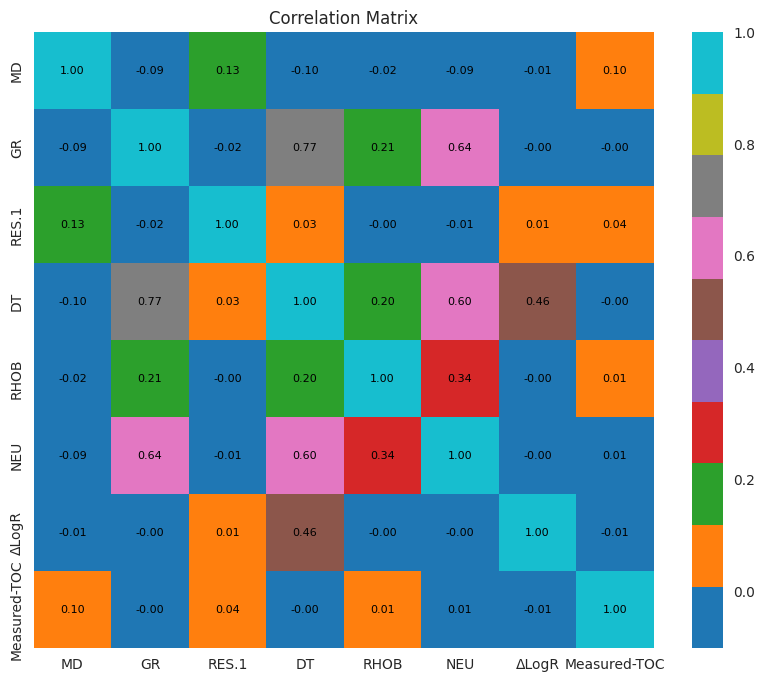

The following variables are highly correlated (>|0.7|):
{'DT'}


In [15]:
plot_correlation_matrix(KR2)

DT shows high correlation of > 0.7 with GR. We can decide to drop DT by this knowledge. however, we will try into ways, what will be it effect when dropped especially on the MVA?

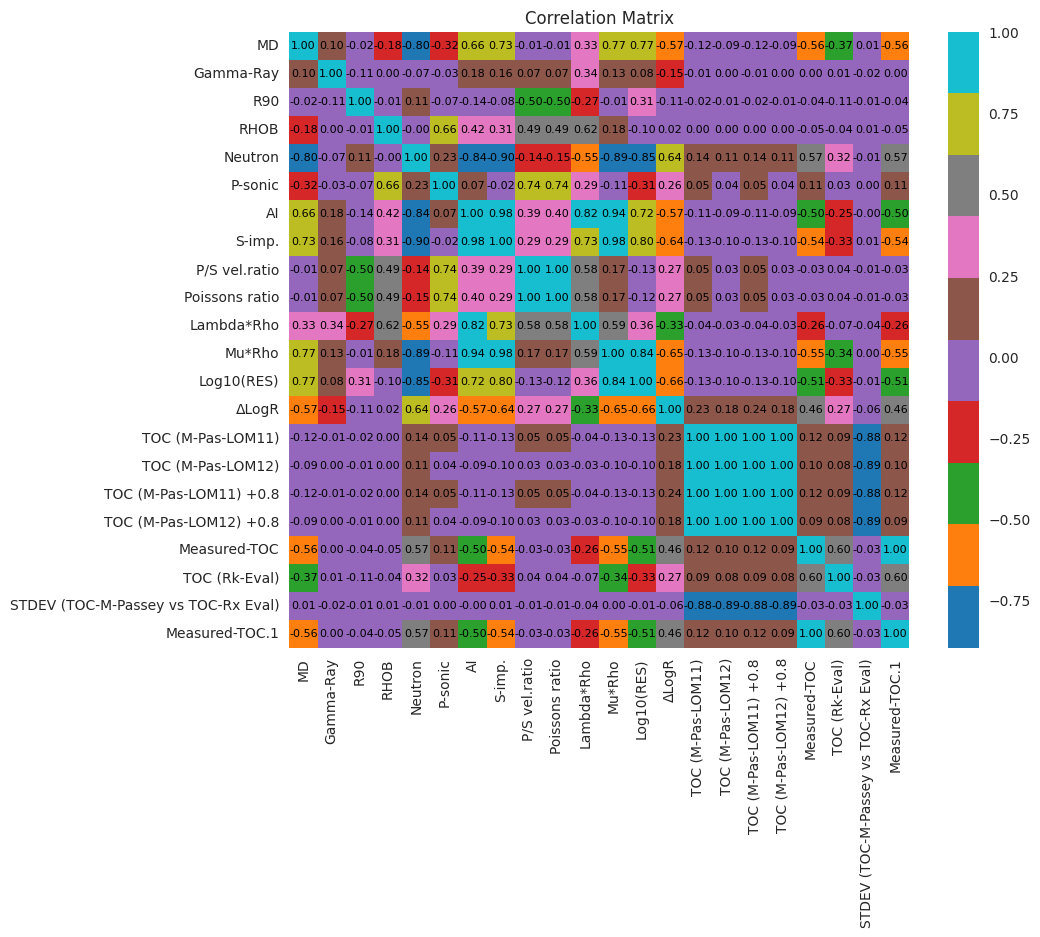

The following variables are highly correlated (>|0.7|):
{'AI', 'Neutron', 'S-imp.', 'Log10(RES)', 'Mu*Rho', 'TOC (M-Pas-LOM12) +0.8', 'Lambda*Rho', 'Measured-TOC.1', 'P/S vel.ratio', 'TOC (M-Pas-LOM12)', 'TOC (M-Pas-LOM11) +0.8', 'STDEV (TOC-M-Passey vs TOC-Rx Eval)', 'Poissons ratio'}


In [16]:
#corelation on the KR3
plot_correlation_matrix(KR3)

In the KR3, following correlation and a benchmark of 0.7, the following were highly correlated {'TOC (M-Pas-LOM11) +0.8', 'S-imp.', 'TOC (M-Pas-LOM12) +0.8', 'AI', 'Poissons ratio', 'Measured-TOC.1', 'Log10(RES)', 'Neutron', 'Lambda*Rho', 'P/S vel.ratio', 'STDEV (TOC-M-Passey vs TOC-Rx Eval)', 'Mu*Rho', 'TOC (M-Pas-LOM12)'} and should be dropped

Upon having this knowledge from correlation we will proceed to having statistical MVA. Mind you, all what we are working was on regression as our target up untill now is a continous variable (Measured-TOC). We will use the Linear Multiple regression method using the Maximum likehood estimate.

When we get to the classifier side of the project, we will use the multivariate logistic regression using logit; here we will have converted and tranformed the measured TOC as a binary class

Starting with the KR2:

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

np.random.seed(9876789)
df1=KR2.copy()
df1=df1.dropna()

# Separate features and target
X_KR2 = df1.drop('Measured-TOC', axis=1)
y_KR2 = df1['Measured-TOC']


#Ordinary least square methods
X_KR2_=sm.add_constant(X_KR2)
model = sm.OLS(y_KR2, X_KR2)
results = model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:           Measured-TOC   R-squared (uncentered):                   0.821
Model:                            OLS   Adj. R-squared (uncentered):              0.821
Method:                 Least Squares   F-statistic:                          2.222e+04
Date:                Fri, 20 Sep 2024   Prob (F-statistic):                        0.00
Time:                        10:07:44   Log-Likelihood:                         -15796.
No. Observations:               33823   AIC:                                  3.161e+04
Df Residuals:                   33816   BIC:                                  3.167e+04
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

The result of the model was 0.82 for rsquared without dropping DT, lets try the same method again but now with dropping DT.

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

df2 = KR2.drop('DT', axis=1)
df2=df2.dropna()

# Separate features and target
X_KR2 = df2.drop('Measured-TOC', axis=1)
y_KR2 = df2['Measured-TOC']


#Ordinary least square methods
X_KR2_=sm.add_constant(X_KR2)
model = sm.OLS(y_KR2, X_KR2)
results = model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:           Measured-TOC   R-squared (uncentered):                   0.821
Model:                            OLS   Adj. R-squared (uncentered):              0.821
Method:                 Least Squares   F-statistic:                          2.590e+04
Date:                Fri, 20 Sep 2024   Prob (F-statistic):                        0.00
Time:                        10:07:47   Log-Likelihood:                         -15812.
No. Observations:               33823   AIC:                                  3.164e+04
Df Residuals:                   33817   BIC:                                  3.169e+04
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

From the two MVA for the KR2, the r2 was same but one thing that stands clear was the report of the model; we can see the condition on the model with the DT variables, please see[3] The condition number is large, 1.31e+03. This might indicate that there are strong multicollinearity or other numerical problems. This is indeed what the correlation has shown us, and we should try to remove multicollinearity either for statistical or ML models. As a result, we will proceed to drop the DT and go with the second summary statistics for KR2.


Following the summary statistics for KR2, only MD, GR, NEU were significant features.



Lets look at the KR3 MVA;

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm


df3=KR3.copy().dropna()

# Separate features and target
X_KR3 = df3.drop('Measured-TOC', axis=1)
y_KR3 = df3['Measured-TOC']


#Ordinary least square methods
X_KR3_=sm.add_constant(X_KR3)
model = sm.OLS(y_KR3, X_KR3)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           Measured-TOC   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 6.299e+08
Date:                Fri, 20 Sep 2024   Prob (F-statistic):               0.00
Time:                        10:07:51   Log-Likelihood:             1.9399e+05
No. Observations:               31291   AIC:                        -3.880e+05
Df Residuals:                   31277   BIC:                        -3.878e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
MD

We have tried to experiment using all features and neglecting the advice from correlation and we get a r2 of 100% which is mostly wrong. with this, we can already see the effect of multicollinearity. we need to drop the features identified from correlations. Lets try and see what we get

In [20]:
# List of columns to drop from KR3
columns_to_drop = ['TOC (M-Pas-LOM11) +0.8', 'S-imp.', 'TOC (M-Pas-LOM12) +0.8', 'AI', 'Poissons ratio', 'Measured-TOC.1', 'Log10(RES)', 'Neutron', 'Lambda*Rho', 'P/S vel.ratio', 'STDEV (TOC-M-Passey vs TOC-Rx Eval)', 'Mu*Rho', 'TOC (M-Pas-LOM12)']

# Drop columns
df4 = KR3.drop(columns=columns_to_drop)


In [21]:
df4=df4.dropna()

# Separate features and target
X_KR3 = df4.drop('Measured-TOC', axis=1)
y_KR3 = df4['Measured-TOC']


#Ordinary least square methods
X_KR3_=sm.add_constant(X_KR3)
model = sm.OLS(y_KR3, X_KR3)
results = model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:           Measured-TOC   R-squared (uncentered):                   0.943
Model:                            OLS   Adj. R-squared (uncentered):              0.943
Method:                 Least Squares   F-statistic:                          6.441e+04
Date:                Fri, 20 Sep 2024   Prob (F-statistic):                        0.00
Time:                        10:08:02   Log-Likelihood:                          6779.3
No. Observations:               31291   AIC:                                 -1.354e+04
Df Residuals:                   31283   BIC:                                 -1.348e+04
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

Even though we have dropped some variables, we can still see there are still chances of multicollinearity in the data, however, this is better than the previous result we got.


Following the summary statistics for KR3 and with 94% r2, 'MD', 'Gamma-Ray', 'R90', 'RHOB', 'P-sonic', 'ΔLogR',
       'TOC (M-Pas-LOM11)', and 'TOC (Rk-Eval)' were significant features.

What we can already see is that df2 which is contains significant features for KR2 using MVA is a new data.

And df4 which contains the significant features established from MVA for KR3 is another new data.

This two data will be tried for downstream regression machine learning model later in this notebook. This is to test if the statistical feature selection outperforms the ML Feature selection

# Lets try the Machine learning feature selection. we will try two ML Feature selection methods: Mutual information and ANOVA

Starting with the KR2 data. Mind you we will use the df2 i.e., the same one used for the MVA

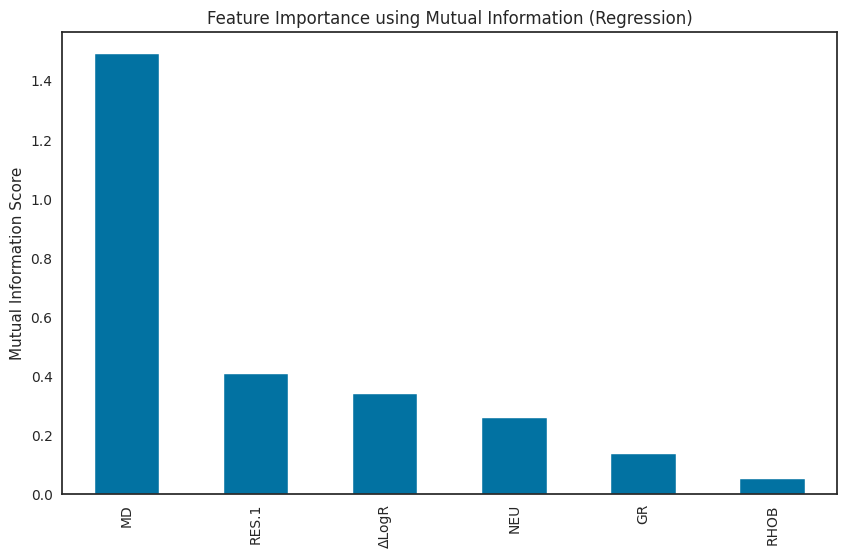

In [39]:
from sklearn.feature_selection import mutual_info_regression
import matplotlib.pyplot as plt
import pandas as pd


# Separate features and target
X_KR2 = df2.drop('Measured-TOC', axis=1)
y_KR2 = df2['Measured-TOC']


# Compute Mutual Information for regression
mutual_info = mutual_info_regression(X_KR2, y_KR2)
mutual_info_series = pd.Series(mutual_info, index=X_KR2.columns).sort_values(ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
mutual_info_series.plot(kind='bar')
plt.title('Feature Importance using Mutual Information (Regression)')
plt.ylabel('Mutual Information Score')
plt.show()


looking at the bar charts, we can see that RHOB has impact but less significant. As a reult, we will use all the six variables.

we will save a dataframe containing the significant variables for KR2 using Mutual information

let try ANOVA

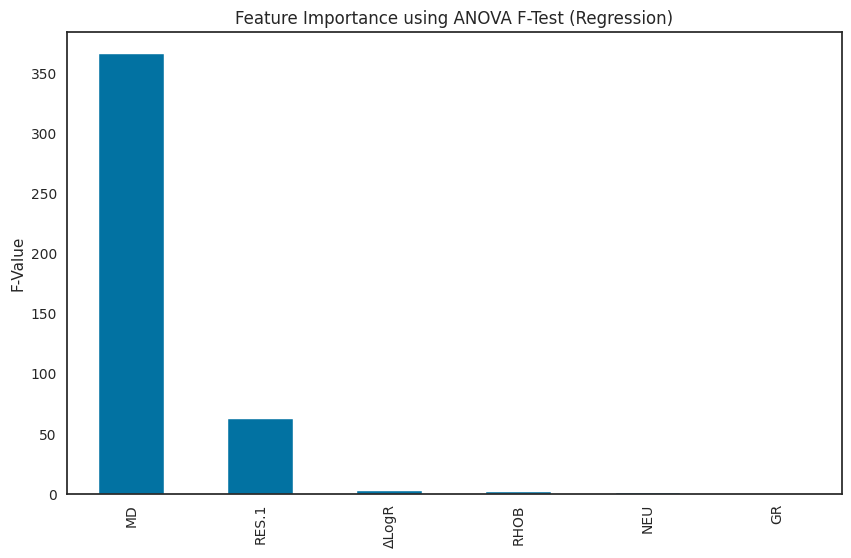

In [40]:
from sklearn.feature_selection import SelectKBest, f_regression
import pandas as pd
import matplotlib.pyplot as plt

# Separate features and target
X_KR2 = df2.drop('Measured-TOC', axis=1)
y_KR2 = df2['Measured-TOC']


# Apply ANOVA F-test for regression
selector = SelectKBest(f_regression, k='all')
selector.fit(X_KR2, y_KR2)

# Plot feature importance using F-values
plt.figure(figsize=(10, 6))
pd.Series(selector.scores_, index=X_KR2.columns).sort_values(ascending=False).plot(kind='bar')
plt.title('Feature Importance using ANOVA F-Test (Regression)')
plt.ylabel('F-Value')
plt.show()


For ANOVA, only MD and RES.1, ΔLogR, RHOB were significant



KR3 Machine Learning Feature selection;

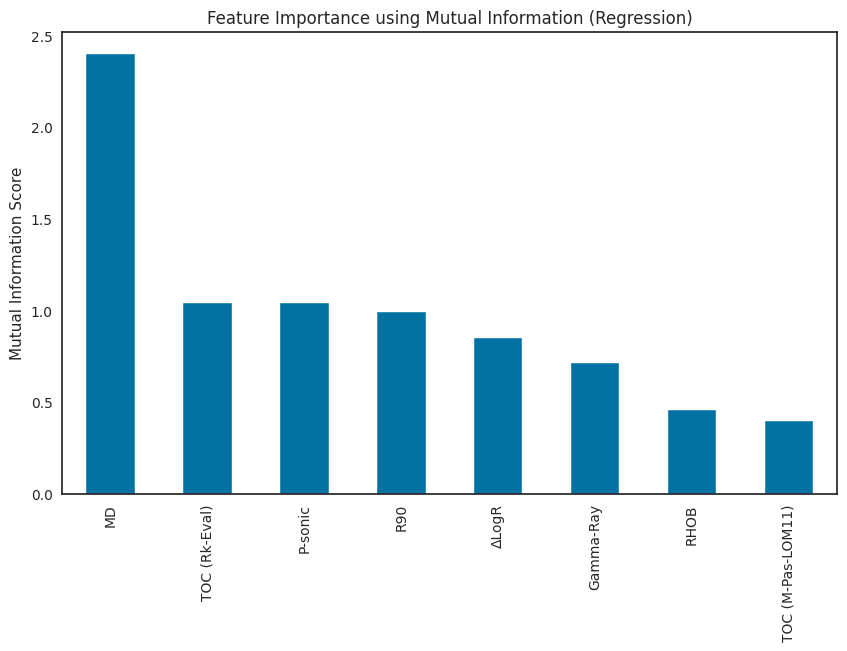

In [44]:
from sklearn.feature_selection import mutual_info_regression
import matplotlib.pyplot as plt
import pandas as pd


# Separate features and target
X_KR3 = df4.drop('Measured-TOC', axis=1)
y_KR3 = df4['Measured-TOC']


# Compute Mutual Information for regression
mutual_info = mutual_info_regression(X_KR3, y_KR3)
mutual_info_series = pd.Series(mutual_info, index=X_KR3.columns).sort_values(ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
mutual_info_series.plot(kind='bar')
plt.title('Feature Importance using Mutual Information (Regression)')
plt.ylabel('Mutual Information Score')
plt.show()


For the Mutual information KR3, we can see that all features were significant which is same with what we got with the statistical MVA

lets try ANOVA

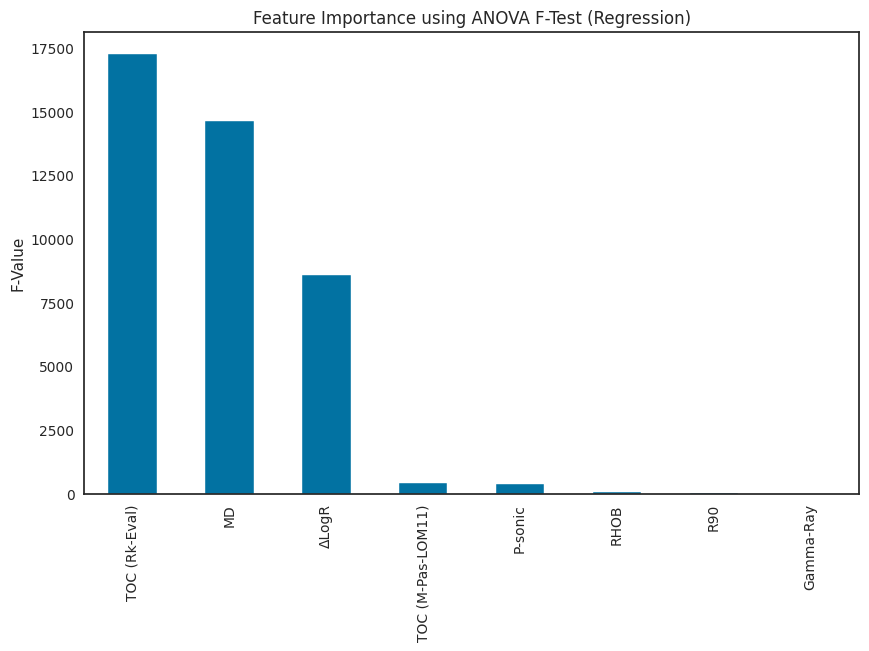

In [45]:
from sklearn.feature_selection import SelectKBest, f_regression
import pandas as pd
import matplotlib.pyplot as plt


# Separate features and target
X_KR3 = df4.drop('Measured-TOC', axis=1)
y_KR3 = df4['Measured-TOC']


# Apply ANOVA F-test for regression
selector = SelectKBest(f_regression, k='all')
selector.fit(X_KR3, y_KR3)

# Plot feature importance using F-values
plt.figure(figsize=(10, 6))
pd.Series(selector.scores_, index=X_KR3.columns).sort_values(ascending=False).plot(kind='bar')
plt.title('Feature Importance using ANOVA F-Test (Regression)')
plt.ylabel('F-Value')
plt.show()


As for the ANOVA FS for the KR3, RHOB, R90 and Gamma-Ray were not sigificant.

Now lets take a look at the features that was selected for KR2 and KR3 for statistical MVA and ML Feature selections.


KR2_MVA:
1. MD,
2. GR,
3. NEU

KR2_MI_Feature_selection:
1. MD
2. GR
3. RES.1
4. RHOB
5. NEU
6. ΔLogR


KR2_ANOVA_Feature_selection:
1. MD
2. RES.1
3. ΔLogR
4. RHOB



KR3_MVA:
1. MD
2. Gamma-Ray
3. R90
4. RHOB
5. P-sonic
6. ΔLogR
7. TOC (M-Pas-LOM11)
8. TOC (Rk-Eval)

KR3_MI_Feature_selection:
1. MD
2. Gamma-Ray
3. R90
4. RHOB
5. P-sonic
6. ΔLogR
7. TOC (M-Pas-LOM11)
8. TOC (Rk-Eval)


KR3_ANOVA_Feature_selection:
1. TOC (Rk-Eval)
2. MD
3. ΔLogR
4. TOC (M-Pas-LOM11)
5. P-sonic







In [22]:
KR2_MVA=df2[['MD', 'GR', 'NEU','Measured-TOC']]
KR2_MI=df2[['MD', 'GR', 'RES.1', 'RHOB', 'NEU', 'ΔLogR','Measured-TOC']]
KR2_ANOVA=df2[['MD', 'RES.1', 'ΔLogR', 'RHOB','Measured-TOC']]

KR3_MVA=df4[['MD', 'Gamma-Ray', 'R90', 'RHOB', 'P-sonic', 'ΔLogR', 'TOC (M-Pas-LOM11)', 'TOC (Rk-Eval)','Measured-TOC']]
KR3_MI=df4[['MD', 'Gamma-Ray', 'R90', 'RHOB', 'P-sonic', 'ΔLogR', 'TOC (M-Pas-LOM11)', 'TOC (Rk-Eval)','Measured-TOC']]
KR3_ANOVA=df4[['TOC (Rk-Eval)', 'MD', 'ΔLogR', 'TOC (M-Pas-LOM11)', 'P-sonic','Measured-TOC']]

Using the significant variables we will do a downstream regression ML model experiment using the different data one each for KR2 and KR3.

I.e., a regression ML model using random forest regressor on KR2_MVA vs KR2_MI vs KR2_ANOVA using a five fold cross validation

KR2_MVA columns: Index(['MD', 'GR', 'NEU', 'Measured-TOC'], dtype='object')
KR2_MI columns: Index(['MD', 'GR', 'RES.1', 'RHOB', 'NEU', 'ΔLogR', 'Measured-TOC'], dtype='object')
KR2_ANOVA columns: Index(['MD', 'RES.1', 'ΔLogR', 'RHOB', 'Measured-TOC'], dtype='object')
     Dataset       MSE      RMSE       MAE       R^2
0    KR2_MVA  0.000409  0.020085  0.007837  0.996330
1     KR2_MI  0.000915  0.030207  0.013070  0.991752
2  KR2_ANOVA  0.000789  0.027965  0.010529  0.993096


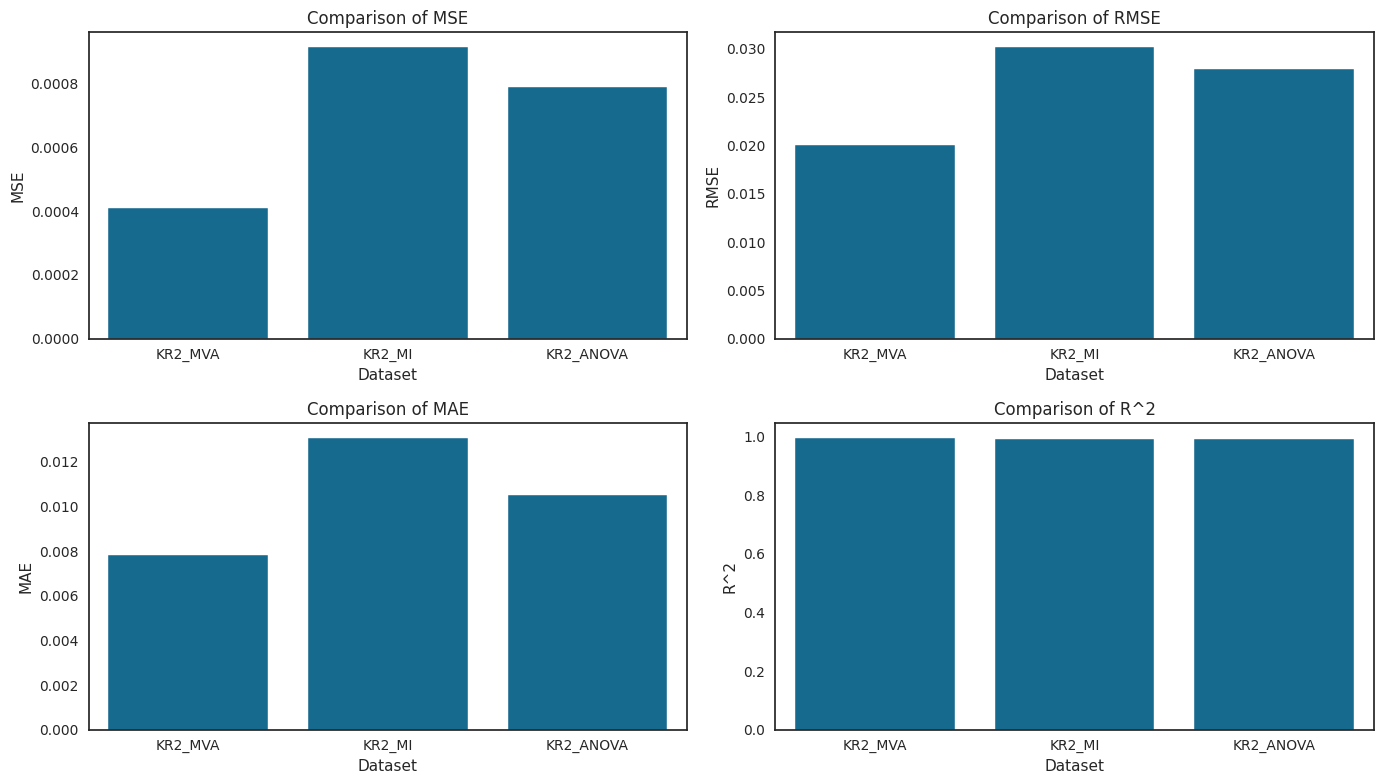

In [23]:
import pandas as pd
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming KR2_MVA, KR2_MI, and KR2_ANOVA are your DataFrames and 'Measured-TOC' is the target variable
datasets = {'KR2_MVA': KR2_MVA, 'KR2_MI': KR2_MI, 'KR2_ANOVA': KR2_ANOVA}
target = 'Measured-TOC'  # Make sure this is the correct target name

# Check the column names for debugging purposes
for name, df in datasets.items():
    print(f"{name} columns: {df.columns}")

# Define the model
model = RandomForestRegressor()

# Create an empty DataFrame to store results
results = pd.DataFrame(columns=['Dataset', 'MSE', 'RMSE', 'MAE', 'R^2'])

# 5-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Loop through the datasets and evaluate performance
for name, df in datasets.items():
    X = df.drop(columns=[target])  # Features
    y = df[target]  # Target

    # Cross-validated metrics
    mse_scores = -cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=kf)
    rmse_scores = np.sqrt(mse_scores)
    mae_scores = -cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=kf)
    r2_scores = cross_val_score(model, X, y, scoring='r2', cv=kf)

    # Create a temporary DataFrame to store the metrics for this dataset
    temp_df = pd.DataFrame({
        'Dataset': [name],
        'MSE': [mse_scores.mean()],
        'RMSE': [rmse_scores.mean()],
        'MAE': [mae_scores.mean()],
        'R^2': [r2_scores.mean()]
    })

    # Concatenate the temp DataFrame with the results DataFrame
    results = pd.concat([results, temp_df], ignore_index=True)

# Display the performance table
print(results)

# Plotting the performance metrics
plt.figure(figsize=(14, 8))
metrics = ['MSE', 'RMSE', 'MAE', 'R^2']

for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 2, i)
    sns.barplot(x='Dataset', y=metric, data=results)
    plt.title(f'Comparison of {metric}')
    plt.ylabel(metric)

plt.tight_layout()
plt.show()


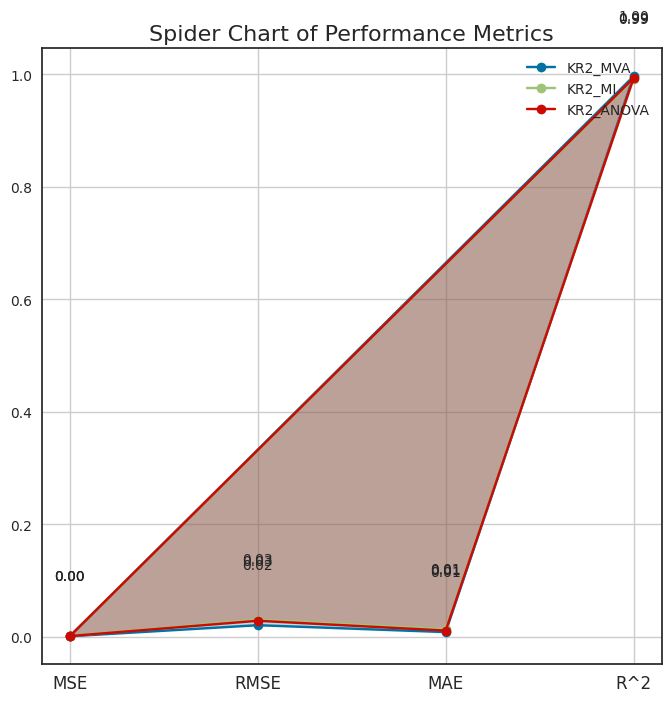

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# Define the metrics and number of datasets
metrics = ['MSE', 'RMSE', 'MAE', 'R^2']
num_metrics = len(metrics)

# Prepare the radar chart
angles = np.linspace(0, 2 * np.pi, num_metrics, endpoint=False).tolist()
angles += angles[:1]  # Close the loop for the polygon

# Create a figure
plt.figure(figsize=(8, 8))

# Loop through each dataset to create the radar chart
for index, row in results.iterrows():
    values = row[metrics].values.flatten().tolist()
    values += values[:1]  # Close the loop

    # Plot the polygon
    plt.fill(angles, values, alpha=0.25)
    plt.plot(angles, values, label=row['Dataset'], marker='o')

    # Add labels and scores for each metric with adjusted positioning
    for angle, value in zip(angles[:-1], values[:-1]):
        offset = 0.1 if value >= 0 else -0.1  # Adjust offset based on value
        plt.text(angle, value + offset, f'{value:.2f}', horizontalalignment='center', size=10)

# Add the labels for the metrics
plt.xticks(angles[:-1], metrics, fontsize=12)
plt.title('Spider Chart of Performance Metrics', fontsize=16)
plt.legend(loc='upper right')
plt.grid(True)

# Show the plot
plt.show()


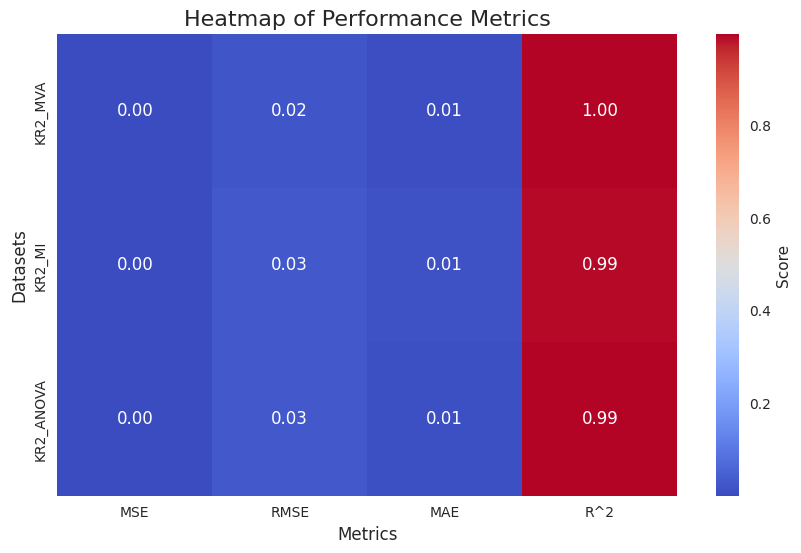

In [27]:
# Create a heatmap for the performance metrics
heatmap_data = results.set_index('Dataset')[metrics]

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap='coolwarm', cbar_kws={'label': 'Score'})
plt.title('Heatmap of Performance Metrics', fontsize=16)
plt.xlabel('Metrics', fontsize=12)
plt.ylabel('Datasets', fontsize=12)
plt.show()


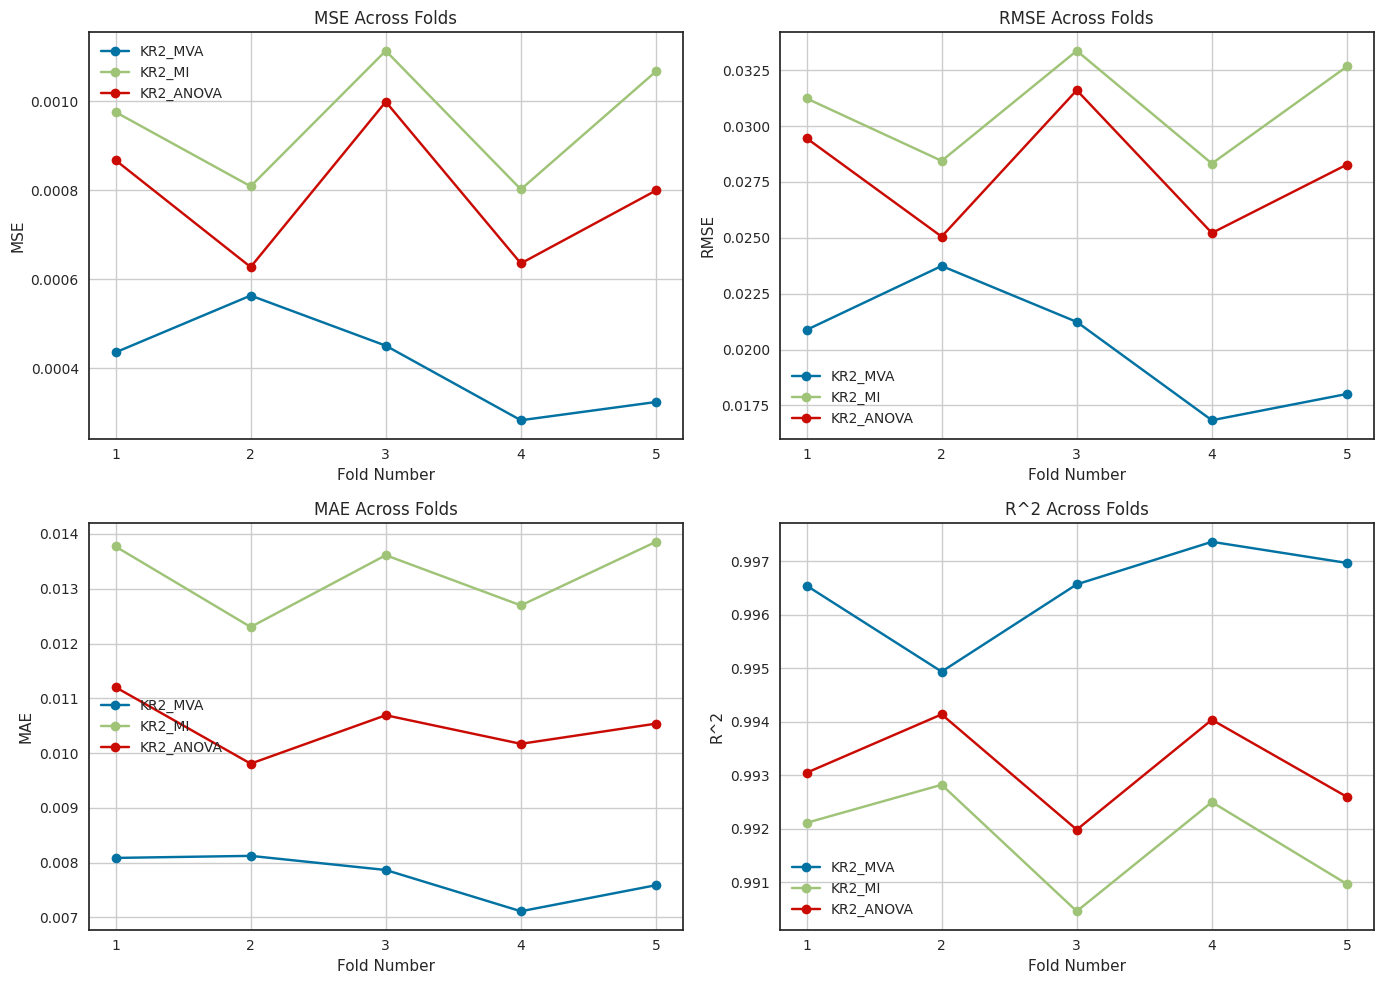

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor

# Example dataframes
datasets = {'KR2_MVA': KR2_MVA, 'KR2_MI': KR2_MI, 'KR2_ANOVA': KR2_ANOVA}
target = 'Measured-TOC'
model = RandomForestRegressor()

# Prepare to collect fold-wise scores
fold_results = {name: {metric: [] for metric in ['MSE', 'RMSE', 'MAE', 'R^2']} for name in datasets.keys()}

# 5-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Loop through the datasets and perform cross-validation
for name, df in datasets.items():
    X = df.drop(columns=[target])
    y = df[target]

    mse_scores = -cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=kf)
    rmse_scores = np.sqrt(mse_scores)
    mae_scores = -cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=kf)
    r2_scores = cross_val_score(model, X, y, scoring='r2', cv=kf)

    # Store fold-wise scores
    fold_results[name]['MSE'] = mse_scores.tolist()
    fold_results[name]['RMSE'] = rmse_scores.tolist()
    fold_results[name]['MAE'] = mae_scores.tolist()
    fold_results[name]['R^2'] = r2_scores.tolist()

# Create a line chart for each metric
metrics = ['MSE', 'RMSE', 'MAE', 'R^2']
plt.figure(figsize=(14, 10))

for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 2, i)

    for dataset, scores in fold_results.items():
        plt.plot(range(1, 6), scores[metric], marker='o', label=dataset)

    plt.title(f'{metric} Across Folds')
    plt.xlabel('Fold Number')
    plt.ylabel(metric)
    plt.xticks(range(1, 6))
    plt.legend()
    plt.grid()

plt.tight_layout()
plt.show()

Lets try same for KR3

KR3_MVA columns: Index(['MD', 'Gamma-Ray', 'R90', 'RHOB', 'P-sonic', 'ΔLogR',
       'TOC (M-Pas-LOM11)', 'TOC (Rk-Eval)', 'Measured-TOC'],
      dtype='object')
KR3_MI columns: Index(['MD', 'Gamma-Ray', 'R90', 'RHOB', 'P-sonic', 'ΔLogR',
       'TOC (M-Pas-LOM11)', 'TOC (Rk-Eval)', 'Measured-TOC'],
      dtype='object')
KR3_ANOVA columns: Index(['TOC (Rk-Eval)', 'MD', 'ΔLogR', 'TOC (M-Pas-LOM11)', 'P-sonic',
       'Measured-TOC'],
      dtype='object')
     Dataset       MSE      RMSE       MAE       R^2
0    KR3_MVA  0.000066  0.008019  0.002268  0.998895
1     KR3_MI  0.000067  0.008078  0.002267  0.998936
2  KR3_ANOVA  0.000044  0.006477  0.001646  0.999311


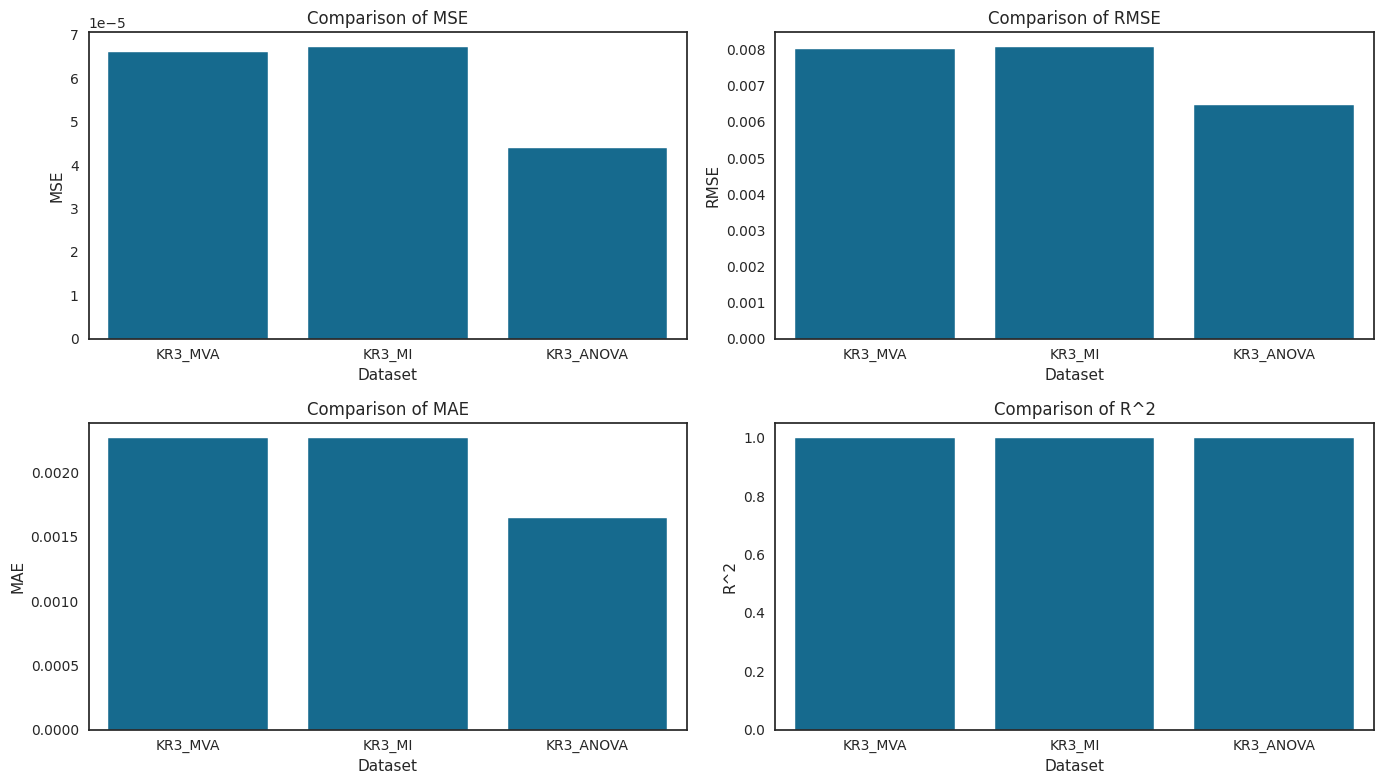

In [31]:
import pandas as pd
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming KR2_MVA, KR2_MI, and KR2_ANOVA are your DataFrames and 'Measured-TOC' is the target variable
datasets = {'KR3_MVA': KR3_MVA, 'KR3_MI': KR3_MI, 'KR3_ANOVA': KR3_ANOVA}
target = 'Measured-TOC'  # Make sure this is the correct target name

# Check the column names for debugging purposes
for name, df in datasets.items():
    print(f"{name} columns: {df.columns}")

# Define the model
model = RandomForestRegressor()

# Create an empty DataFrame to store results
results = pd.DataFrame(columns=['Dataset', 'MSE', 'RMSE', 'MAE', 'R^2'])

# 5-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Loop through the datasets and evaluate performance
for name, df in datasets.items():
    X = df.drop(columns=[target])  # Features
    y = df[target]  # Target

    # Cross-validated metrics
    mse_scores = -cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=kf)
    rmse_scores = np.sqrt(mse_scores)
    mae_scores = -cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=kf)
    r2_scores = cross_val_score(model, X, y, scoring='r2', cv=kf)

    # Create a temporary DataFrame to store the metrics for this dataset
    temp_df = pd.DataFrame({
        'Dataset': [name],
        'MSE': [mse_scores.mean()],
        'RMSE': [rmse_scores.mean()],
        'MAE': [mae_scores.mean()],
        'R^2': [r2_scores.mean()]
    })

    # Concatenate the temp DataFrame with the results DataFrame
    results = pd.concat([results, temp_df], ignore_index=True)

# Display the performance table
print(results)

# Plotting the performance metrics
plt.figure(figsize=(14, 8))
metrics = ['MSE', 'RMSE', 'MAE', 'R^2']

for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 2, i)
    sns.barplot(x='Dataset', y=metric, data=results)
    plt.title(f'Comparison of {metric}')
    plt.ylabel(metric)

plt.tight_layout()
plt.show()


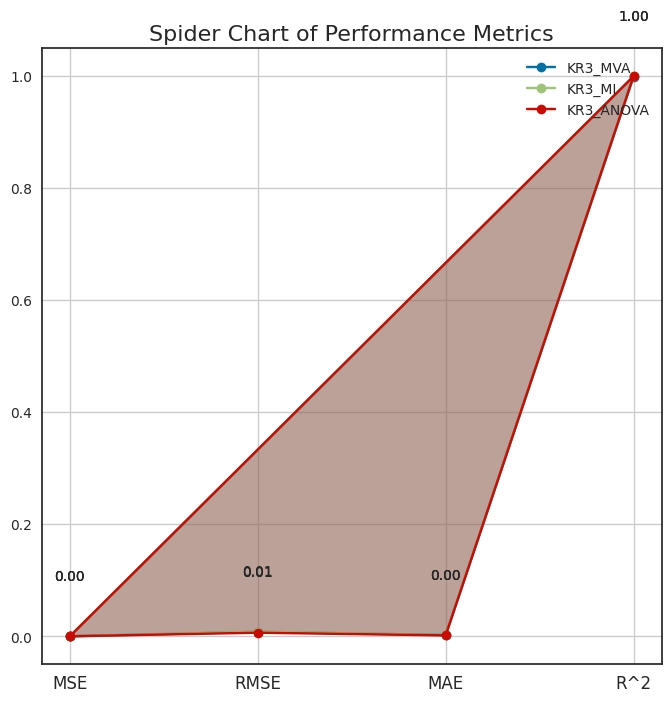

In [32]:
import numpy as np
import matplotlib.pyplot as plt

# Define the metrics and number of datasets
metrics = ['MSE', 'RMSE', 'MAE', 'R^2']
num_metrics = len(metrics)

# Prepare the radar chart
angles = np.linspace(0, 2 * np.pi, num_metrics, endpoint=False).tolist()
angles += angles[:1]  # Close the loop for the polygon

# Create a figure
plt.figure(figsize=(8, 8))

# Loop through each dataset to create the radar chart
for index, row in results.iterrows():
    values = row[metrics].values.flatten().tolist()
    values += values[:1]  # Close the loop

    # Plot the polygon
    plt.fill(angles, values, alpha=0.25)
    plt.plot(angles, values, label=row['Dataset'], marker='o')

    # Add labels and scores for each metric with adjusted positioning
    for angle, value in zip(angles[:-1], values[:-1]):
        offset = 0.1 if value >= 0 else -0.1  # Adjust offset based on value
        plt.text(angle, value + offset, f'{value:.2f}', horizontalalignment='center', size=10)

# Add the labels for the metrics
plt.xticks(angles[:-1], metrics, fontsize=12)
plt.title('Spider Chart of Performance Metrics', fontsize=16)
plt.legend(loc='upper right')
plt.grid(True)

# Show the plot
plt.show()

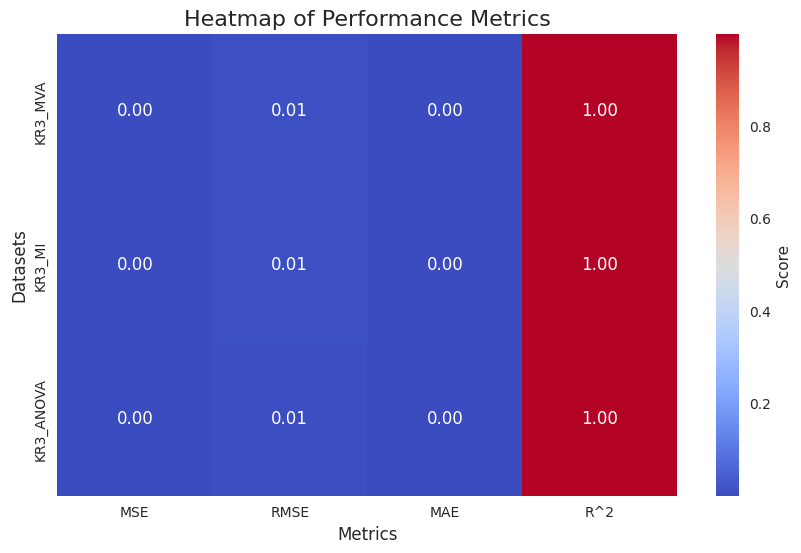

In [33]:
# Create a heatmap for the performance metrics
heatmap_data = results.set_index('Dataset')[metrics]

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap='coolwarm', cbar_kws={'label': 'Score'})
plt.title('Heatmap of Performance Metrics', fontsize=16)
plt.xlabel('Metrics', fontsize=12)
plt.ylabel('Datasets', fontsize=12)
plt.show()

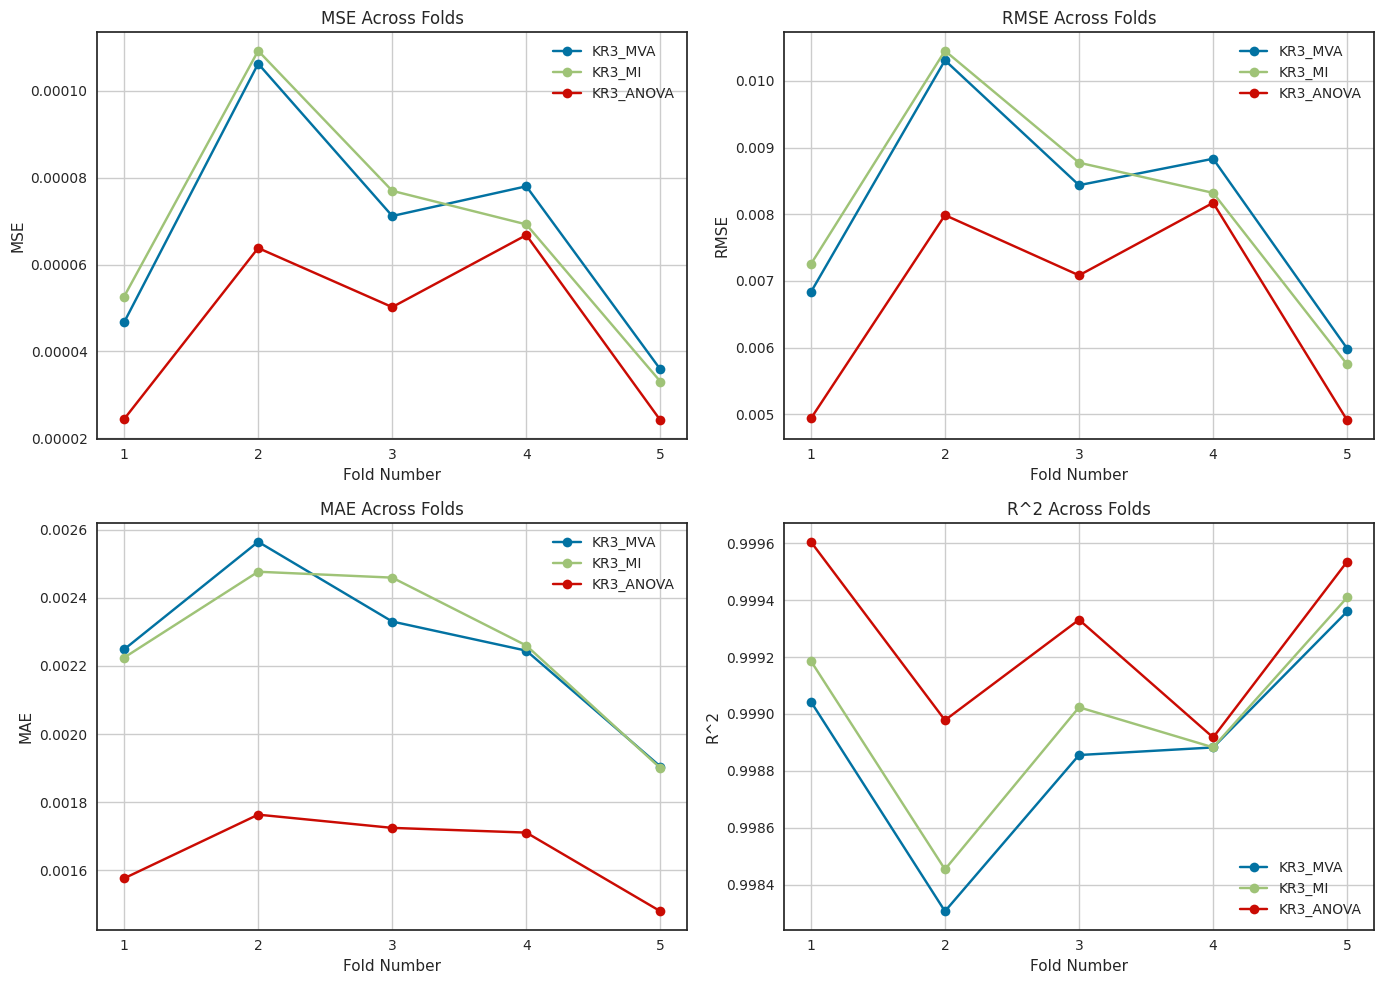

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor

# Example dataframes
datasets = {'KR3_MVA': KR3_MVA, 'KR3_MI': KR3_MI, 'KR3_ANOVA': KR3_ANOVA}
target = 'Measured-TOC'
model = RandomForestRegressor()

# Prepare to collect fold-wise scores
fold_results = {name: {metric: [] for metric in ['MSE', 'RMSE', 'MAE', 'R^2']} for name in datasets.keys()}

# 5-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Loop through the datasets and perform cross-validation
for name, df in datasets.items():
    X = df.drop(columns=[target])
    y = df[target]

    mse_scores = -cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=kf)
    rmse_scores = np.sqrt(mse_scores)
    mae_scores = -cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=kf)
    r2_scores = cross_val_score(model, X, y, scoring='r2', cv=kf)

    # Store fold-wise scores
    fold_results[name]['MSE'] = mse_scores.tolist()
    fold_results[name]['RMSE'] = rmse_scores.tolist()
    fold_results[name]['MAE'] = mae_scores.tolist()
    fold_results[name]['R^2'] = r2_scores.tolist()

# Create a line chart for each metric
metrics = ['MSE', 'RMSE', 'MAE', 'R^2']
plt.figure(figsize=(14, 10))

for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 2, i)

    for dataset, scores in fold_results.items():
        plt.plot(range(1, 6), scores[metric], marker='o', label=dataset)

    plt.title(f'{metric} Across Folds')
    plt.xlabel('Fold Number')
    plt.ylabel(metric)
    plt.xticks(range(1, 6))
    plt.legend()
    plt.grid()

plt.tight_layout()
plt.show()

Investigate the model from a classification point. Here there is a classification boundary in Passey excel file, exactly on Sheet 1 of the file.

The category is as follows.
    if toc_value < 0.5:
        return 'Poor'
    elif 0.5 <= toc_value < 1:
        return 'Fair'
    elif 1 <= toc_value < 2:
        return 'Good'
    elif 2 <= toc_value < 4:
        return 'V.Good'
    else:
        return 'Excellent'
However, we will reformat this to binary class and have.

if 0.5 <= toc_value < 1:
        return 'Fair'
    elif 1 <= toc_value < 4:
        return 'Good'


In [ ]:
def categorize_toc(toc_value):
    """
    Categorize Measured TOC values into qualitative labels.

    Parameters:
    toc_value (float): Measured TOC value.

    Returns:
    str: Categorical label.
    """
    if 0.5< toc_value < 1:
        return '0' #fair
    elif 1 <= toc_value < 4:
        return '1' #good